In [ ]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480

In [ ]:
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
# disable_progress_bar controls the visibility of progress bars
from torch.utils.data import DataLoader
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

from flwr_datasets.partitioner import DirichletPartitioner
partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS,alpha=0.05,partition_by="label",seed=42)

In [ ]:
def load_datasets(partition_id: int):
    fds=FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})
    partition=fds.load_partition(partition_id)

    print(f"Partition {partition_id} size: {len(partition)}")
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    print(f"Partition {partition_id} train size: {len(partition_train_test['train'])}")
    print(f"Partition {partition_id} test size: {len(partition_train_test['test'])}")

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )
    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    train_batch_size = min(BATCH_SIZE, max(2, len(partition_train_test["train"])))

    trainloader = DataLoader(
        partition_train_test["train"],
        batch_size=train_batch_size,
        shuffle=True,
        drop_last=(len(partition_train_test["train"]) % train_batch_size == 1)
    )

    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
        drop_last=(len(partition_train_test["test"]) == 1)
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict()
    for k, v in params_dict:
        if v.size == 0:
            print(f"Warning: Parameter {k} is empty!")
            continue
        state_dict[k] = torch.tensor(v)

    net.load_state_dict(state_dict, strict=True)

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    # optimizer = torch.optim.Adam(net.parameters())

    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images,labels=batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            if images.size(0)<=1:
                continue
            else:
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                total += labels.size(0)
                correct += (torch.max(outputs.data,1)[1]==labels).sum().item()

        if total>0:
            epoch_loss /= total
            epoch_acc = correct / total
            if verbose:
                print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

In [ ]:
def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    print(f"Context data: {context.__dict__}")

    partition_id = int(context.node_id) % NUM_CLIENTS if hasattr(context, 'node_id') else 0
    if hasattr(context, 'node_config') and 'partition_id' in context.node_config:
        partition_id = context.node_config['partition_id']

    print(f"Using partition_id: {partition_id}")
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)
    return FlowerClient(net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
test_accuracies = []
loss_values = []

class CustomFedAvg(FedAvg):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            test_accuracies.append(accuracy)
            loss_values.append(loss)
            print(f"Round {server_round}: Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1244) 2025-05-01 01:04:54.675246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1244) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1244) E0000 00:00:1746061494.766859    1244 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1244) E0000 00:00:1746061494.796109    1244 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=1244) /usr/local/lib/python3.11/dist-packages/jupyter_client/co

(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5


Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 115830.51 examples/s]
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_rec

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Test Loss: 0.0691, Test Accuracy: 0.1631
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=1244) Partition 6 size: 570
(ClientAppActor pid=1244) Partition 6 train size: 456
(ClientAppActor pid=1244) Partition 6 test size: 114


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 2: Test Loss: 0.0734, Test Accuracy: 0.1035
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Test Loss: 0.0841, Test Accuracy: 0.0424
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1244) Partition 6 size: 570
(ClientAppActor pid=1244) Partition 6 train size: 456
(ClientAppActor pid=1244) Partition 6 test size: 114
Round 4: Test Loss: 0.0794, Test Accuracy: 0.0113
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Test Loss: 0.0740, Test Accuracy: 0.0802
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Test Loss: 0.0562, Test Accuracy: 0.3682
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1244) Partition 6 size: 570
(ClientAppActor pid=1244) Partition 6 train size: 456
(ClientAppActor pid=1244) Partition 6 test size: 114
Round 7: Test Loss: 0.0772, Test Accuracy: 0.0288
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 8: Test Loss: 0.0670, Test Accuracy: 0.1493
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Clie

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Test Loss: 0.0486, Test Accuracy: 0.4168
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(ClientAppActor pid=1244) Partition 3 size: 4835
(ClientAppActor pid=1244) Partition 3 train size: 3868
(ClientAppActor pid=1244) Partition 3 test size: 967
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6456378906235776463, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Test Loss: 0.0729, Test Accuracy: 0.1690
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 11: Test Loss: 0.0634, Test Accuracy: 0.1589
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Test Loss: 0.0651, Test Accuracy: 0.1627
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Test Loss: 0.0442, Test Accuracy: 0.5037
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6456378906235776463, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Test Loss: 0.0508, Test Accuracy: 0.4211
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Test Loss: 0.0522, Test Accuracy: 0.3850
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6456378906235776463, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Test Loss: 0.0520, Test Accuracy: 0.4034
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1244) Partition 6 size: 570
(ClientAppActor pid=1244) Partition 6 train size: 456
(ClientAppActor pid=1244) Partition 6 test size: 114
Round 17: Test Loss: 0.0685, Test Accuracy: 0.2223
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_r

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Test Loss: 0.0535, Test Accuracy: 0.3793
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Test Loss: 0.0491, Test Accuracy: 0.4120
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Test Loss: 0.0515, Test Accuracy: 0.3923
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Test Loss: 0.0605, Test Accuracy: 0.2865
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cl

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Test Loss: 0.0490, Test Accuracy: 0.4171
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6456378906235776463, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Test Loss: 0.0421, Test Accuracy: 0.5221
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Test Loss: 0.0461, Test Accuracy: 0.4584
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Test Loss: 0.0446, Test Accuracy: 0.4879
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Test Loss: 0.0552, Test Accuracy: 0.3453
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Test Loss: 0.0618, Test Accuracy: 0.2449
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 28: Test Loss: 0.0439, Test Accuracy: 0.5295
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Test Loss: 0.0556, Test Accuracy: 0.3210
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(ClientAppActor pid=1244) Partition 3 size: 4835
(ClientAppActor pid=1244) Partition 3 train size: 3868
(ClientAppActor pid=1244) Partition 3 test size: 967
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6456378906235776463, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 30: Test Loss: 0.0646, Test Accuracy: 0.2416
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Test Loss: 0.0564, Test Accuracy: 0.3515
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 32: Test Loss: 0.0366, Test Accuracy: 0.5935
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Test Loss: 0.0538, Test Accuracy: 0.3877
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cl

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Test Loss: 0.0441, Test Accuracy: 0.5045
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1244) Partition 6 size: 570
(ClientAppActor pid=1244) Partition 6 train size: 456
(ClientAppActor pid=1244) Partition 6 test size: 114
Round 35: Test Loss: 0.0580, Test Accuracy: 0.2780
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_r

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Test Loss: 0.0584, Test Accuracy: 0.3094
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 37: Test Loss: 0.0602, Test Accuracy: 0.3095
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Test Loss: 0.0561, Test Accuracy: 0.3597
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cl

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Test Loss: 0.0542, Test Accuracy: 0.3656
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1244) Partition 6 size: 570
(ClientAppActor pid=1244) Partition 6 train size: 456
(ClientAppActor pid=1244) Partition 6 test size: 114
Round 40: Test Loss: 0.0595, Test Accuracy: 0.2931
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_r

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6456378906235776463, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Test Loss: 0.0367, Test Accuracy: 0.5891
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Test Loss: 0.0339, Test Accuracy: 0.6286
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Test Loss: 0.0565, Test Accuracy: 0.2956
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 5806170494479890028, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 8
(ClientAppActor pid=1244) Partition 8 size: 19003
(ClientAppActor pid=1244) Partition 8 train size: 15202
(ClientAppActor pid=1244) Partition 8 test size: 3801
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 16291858208511737629, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 9
(Cl

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=1244) Partition 6 size: 570
(ClientAppActor pid=1244) Partition 6 train size: 456
(ClientAppActor pid=1244) Partition 6 test size: 114
Round 44: Test Loss: 0.0374, Test Accuracy: 0.5921
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Test Loss: 0.0543, Test Accuracy: 0.3388
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 46: Test Loss: 0.0491, Test Accuracy: 0.3804
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6456378906235776463, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Test Loss: 0.0519, Test Accuracy: 0.3806
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6456378906235776463, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Test Loss: 0.0392, Test Accuracy: 0.5498
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6456378906235776463, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 9201117564061148782, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 11424933260275462063, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 3
(Clien

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Test Loss: 0.0429, Test Accuracy: 0.4975
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 1660903106926413842, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 2
(ClientAppActor pid=1244) Partition 2 size: 2133
(ClientAppActor pid=1244) Partition 2 train size: 1706
(ClientAppActor pid=1244) Partition 2 test size: 427
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(Cli

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 6091041286331792095, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(ClientAppActor pid=1244) Partition 5 size: 4272
(ClientAppActor pid=1244) Partition 5 train size: 3417
(ClientAppActor pid=1244) Partition 5 test size: 855
(ClientAppActor pid=1244) Context data: {'run_id': 16001953042095171996, 'node_id': 7275345501562518485, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=1244)   array_records={},
(ClientAppActor pid=1244)   metric_records={},
(ClientAppActor pid=1244)   config_records={}
(ClientAppActor pid=1244) ), 'run_config': {}}
(ClientAppActor pid=1244) Using partition_id: 5
(Client

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 2773.41s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.06911025692288253
INFO :      		round 2: 0.07337898914841265
INFO :      		round 3: 0.08407232332069944
INFO :      		round 4: 0.07935178548314309
INFO :      		round 5: 0.0740033318069351
INFO :      		round 6: 0.05619661243298425
INFO :      		round 7: 0.07721471189908716
INFO :      		round 8: 0.06695166189374467
INFO :      		round 9: 0.048566719853918514
INFO :      		round 10: 0.07287496413211098
INFO :      		round 11: 0.06338836483333789
INFO :      		round 12: 0.06512811590617372
INFO :      		round 13: 0.04422804231367307
INFO :      		round 14: 0.050810080423409246
INFO :      		round 15: 0.05217007245994641
INFO :      		round 16: 0.05204515076956304
INFO :      		round 17: 0.06854342714983615
INFO :      		round 18: 0.05352117631573375
INFO :      		round 19: 

Round 50: Test Loss: 0.0441, Test Accuracy: 0.4511


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(test_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.1631
Round 2: 0.1035
Round 3: 0.0424
Round 4: 0.0113
Round 5: 0.0802
Round 6: 0.3682
Round 7: 0.0288
Round 8: 0.1493
Round 9: 0.4168
Round 10: 0.1690
Round 11: 0.1589
Round 12: 0.1627
Round 13: 0.5037
Round 14: 0.4211
Round 15: 0.3850
Round 16: 0.4034
Round 17: 0.2223
Round 18: 0.3793
Round 19: 0.4120
Round 20: 0.3923
Round 21: 0.2865
Round 22: 0.4171
Round 23: 0.5221
Round 24: 0.4584
Round 25: 0.4879
Round 26: 0.3453
Round 27: 0.2449
Round 28: 0.5295
Round 29: 0.3210
Round 30: 0.2416
Round 31: 0.3515
Round 32: 0.5935
Round 33: 0.3877
Round 34: 0.5045
Round 35: 0.2780
Round 36: 0.3094
Round 37: 0.3095
Round 38: 0.3597
Round 39: 0.3656
Round 40: 0.2931
Round 41: 0.5891
Round 42: 0.6286
Round 43: 0.2956
Round 44: 0.5921
Round 45: 0.3388
Round 46: 0.3804
Round 47: 0.3806
Round 48: 0.5498
Round 49: 0.4975
Round 50: 0.4511



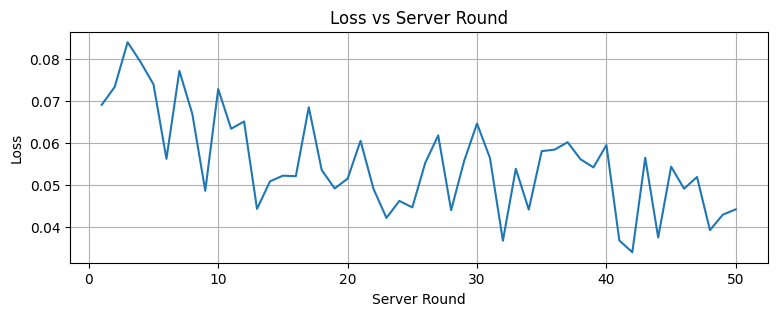

In [ ]:
def plot_loss():
    plt.figure(figsize=(9,3))
    plt.plot(range(1, len(loss_values) + 1), loss_values, linestyle='-')
    plt.title('Loss vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss()

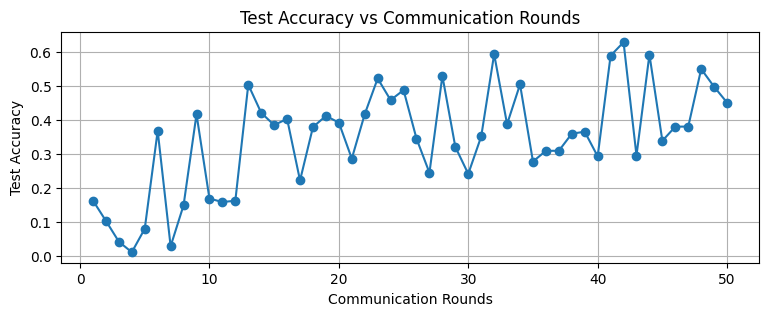

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

In [ ]:
from flwr.server.strategy import FedAvgM # Federated average with momentum

testm_accuracies = []
lossm_values = []

class CustomFedAvgM(FedAvgM):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result=super().aggregate_evaluate(server_round,results,failures)

        if aggregated_result is not None:
            loss,metrics=aggregated_result
            accuracy=metrics.get("accuracy",0.0)
            testm_accuracies.append(accuracy)
            lossm_values.append(loss)
            print(f"Round {server_round}: Loss: {loss:.4f} Test Accuracy: {accuracy:.4f}")
        return aggregated_result

In [ ]:
params = get_parameters(Net())
from flwr.common import ndarrays_to_parameters

strategy = CustomFedAvgM(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    initial_parameters=ndarrays_to_parameters(params),
    server_learning_rate=1.0, #Learning rate
    server_momentum=0.9 #Momentum
)

def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=19431) 2025-05-01 01:51:32.782379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=19431) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=19431) E0000 00:00:1746064292.804267   19431 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=19431) E0000 00:00:1746064292.810443   19431 cuda_blas.cc:1418] Unable to register cuBLAS factor

(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partit

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Loss: 0.0536 Test Accuracy: 0.3468
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
Round 2: Loss: 0.0638 Test Accuracy: 0.3316
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 3: Loss: 0.0572 Test Accuracy: 0.3708
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1
(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Loss: 0.0567 Test Accuracy: 0.2585
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
Round 5: Loss: 0.0598 Test Accuracy: 0.3746
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)  

ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=19431, ip=172.28.0.12, actor_id=51224988642dbe1f58945edf01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ed3c4230b50>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=19431, ip=172.28.0.12, actor_id=51224988642dbe1f58945edf01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ed3c4230b50>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=message, 

(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Loss: 0.0616 Test Accuracy: 0.3020
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1
(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 7: Loss: 0.0511 Test Accuracy: 0.3609
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
Round 8: Loss: 0.0499 Test Accuracy: 0.3466
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partitio

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
Round 9: Loss: 0.0480 Test Accuracy: 0.4214
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=19431, ip=172.28.0.12, actor_id=51224988642dbe1f58945edf01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ed3c4230b50>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/uoft-cs/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=19431, ip=172.28.0.12, actor_id=51224988642dbe1f58945edf01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ed3c4230b50>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=m

(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_evaluate: received 4 results and 1 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Loss: 0.0544 Test Accuracy: 0.2436
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
Round 11: Loss: 0.0569 Test Accuracy: 0.1362
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 12: Loss: 0.0613 Test Accuracy: 0.0670
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partit

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 13: Loss: 0.0535 Test Accuracy: 0.3472
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Loss: 0.0448 Test Accuracy: 0.3677
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config'

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Loss: 0.0414 Test Accuracy: 0.4801
(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)  

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0
(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Loss: 0.0465 Test Accuracy: 0.4959
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
Round 17: Loss: 0.0421 Test Accuracy: 0.4921
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)  

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5
(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Loss: 0.0398 Test Accuracy: 0.4456
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Loss: 0.0390 Test Accuracy: 0.5042
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 20: Loss: 0.0478 Test Accuracy: 0.4794
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partitio

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
Round 21: Loss: 0.0439 Test Accuracy: 0.4778
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431) 

ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=19431, ip=172.28.0.12, actor_id=51224988642dbe1f58945edf01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ed3c4230b50>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/uoft-cs/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=19431, ip=172.28.0.12, actor_id=51224988642dbe1f58945edf01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ed3c4230b50>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=m

(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 22: Loss: 0.0393 Test Accuracy: 0.5144
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1
(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
Round 23: Loss: 0.0364 Test Accuracy: 0.5371
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0
(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   ar

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5
(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partit

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Loss: 0.0358 Test Accuracy: 0.5259
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 25: Loss: 0.0331 Test Accuracy: 0.5741
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=1943

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Loss: 0.0443 Test Accuracy: 0.4207
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
Round 27: Loss: 0.0468 Test Accuracy: 0.4295
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
Round 28: Loss: 0.0353 Test Accuracy: 0.6164
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Loss: 0.0307 Test Accuracy: 0.6191
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
Round 30: Loss: 0.0374 Test Accuracy: 0.5496
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Loss: 0.0372 Test Accuracy: 0.5333
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
Round 32: Loss: 0.0352 Test Accuracy: 0.5780
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5
(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5
(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 33: Loss: 0.0431 Test Accuracy: 0.5007
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config'

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 34: Loss: 0.0378 Test Accuracy: 0.5587
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Loss: 0.0359 Test Accuracy: 0.5545
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=1943

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Loss: 0.0306 Test Accuracy: 0.6746
(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)  

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
Round 37: Loss: 0.0311 Test Accuracy: 0.6287
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)  

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Loss: 0.0318 Test Accuracy: 0.6031
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5
(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
Round 39: Loss: 0.0408 Test Accuracy: 0.5525
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
Round 40: Loss: 0.0315 Test Accuracy: 0.6482
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partitio

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Loss: 0.0359 Test Accuracy: 0.5814
(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0
(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 42: Loss: 0.0309 Test Accuracy: 0.6399
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partitio

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
Round 43: Loss: 0.0329 Test Accuracy: 0.6095
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Loss: 0.0338 Test Accuracy: 0.6202
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=19431, ip=172.28.0.12, actor_id=51224988642dbe1f58945edf01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ed3c4230b50>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/uoft-cs/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=19431, ip=172.28.0.12, actor_id=51224988642dbe1f58945edf01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ed3c4230b50>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=m

(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0
(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)

INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Loss: 0.0450 Test Accuracy: 0.5143
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=19431, ip=172.28.0.12, actor_id=51224988642dbe1f58945edf01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ed3c4230b50>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=19431, ip=172.28.0.12, actor_id=51224988642dbe1f58945edf01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7ed3c4230b50>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=message, 

(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3012406088105513159, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7815256744576850750, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 0


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
Round 46: Loss: 0.0379 Test Accuracy: 0.5621
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
Round 47: Loss: 0.0232 Test Accuracy: 0.7460
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Loss: 0.0376 Test Accuracy: 0.5955
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16427453229759684389, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config':

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11793997246936612310, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Loss: 0.0308 Test Accuracy: 0.6683
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 9
(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 3419635725741177432, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': 

(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 9 size: 4404
(ClientAppActor pid=19431) Partition 9 train size: 3523
(ClientAppActor pid=19431) Partition 9 test size: 881
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 5592641335717430181, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 1


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 1 size: 940
(ClientAppActor pid=19431) Partition 1 train size: 752
(ClientAppActor pid=19431) Partition 1 test size: 188
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 11030806370698752965, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5


(ClientAppActor pid=19431) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=19431) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 01:51:54 2025).


(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 16250149937016318035, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 5
(ClientAppActor pid=19431) Partition 5 size: 4272
(ClientAppActor pid=19431) Partition 5 train size: 3417
(ClientAppActor pid=19431) Partition 5 test size: 855


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 12956587391666314042, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partition_id: 2
(ClientAppActor pid=19431) Partition 2 size: 2133
(ClientAppActor pid=19431) Partition 2 train size: 1706
(ClientAppActor pid=19431) Partition 2 test size: 427
(ClientAppActor pid=19431) Context data: {'run_id': 11321360020864946276, 'node_id': 7544346435247667389, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=19431)   array_records={},
(ClientAppActor pid=19431)   metric_records={},
(ClientAppActor pid=19431)   config_records={}
(ClientAppActor pid=19431) ), 'run_config': {}}
(ClientAppActor pid=19431) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 1970.89s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05356694775039979
INFO :      		round 2: 0.06384820426754828
INFO :      		round 3: 0.057183248151416274
INFO :      		round 4: 0.05668129656606181
INFO :      		round 5: 0.05978032663471991
INFO :      		round 6: 0.06160144358795101
INFO :      		round 7: 0.05112771174705305
INFO :      		round 8: 0.049936606220280635
INFO :      		round 9: 0.04795438946114342
INFO :      		round 10: 0.054432821131353476
INFO :      		round 11: 0.05687329348034089
INFO :      		round 12: 0.06132205751722477
INFO :      		round 13: 0.053532193447597166
INFO :      		round 14: 0.044756706169448074
INFO :      		round 15: 0.04144421645019433
INFO :      		round 16: 0.04653790008132974
INFO :      		round 17: 0.0421288298537257
INFO :      		round 18: 0.03976675480693829
INFO :      		round 1

(ClientAppActor pid=19431) Partition 0 size: 474
(ClientAppActor pid=19431) Partition 0 train size: 379
(ClientAppActor pid=19431) Partition 0 test size: 95
Round 50: Loss: 0.0308 Test Accuracy: 0.6951


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(testm_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====
Round 1: 0.3468
Round 2: 0.3316
Round 3: 0.3708
Round 4: 0.2585
Round 5: 0.3746
Round 6: 0.3020
Round 7: 0.3609
Round 8: 0.3466
Round 9: 0.4214
Round 10: 0.2436
Round 11: 0.1362
Round 12: 0.0670
Round 13: 0.3472
Round 14: 0.3677
Round 15: 0.4801
Round 16: 0.4959
Round 17: 0.4921
Round 18: 0.4456
Round 19: 0.5042
Round 20: 0.4794
Round 21: 0.4778
Round 22: 0.5144
Round 23: 0.5371
Round 24: 0.5259
Round 25: 0.5741
Round 26: 0.4207
Round 27: 0.4295
Round 28: 0.6164
Round 29: 0.6191
Round 30: 0.5496
Round 31: 0.5333
Round 32: 0.5780
Round 33: 0.5007
Round 34: 0.5587
Round 35: 0.5545
Round 36: 0.6746
Round 37: 0.6287
Round 38: 0.6031
Round 39: 0.5525
Round 40: 0.6482
Round 41: 0.5814
Round 42: 0.6399
Round 43: 0.6095
Round 44: 0.6202
Round 45: 0.5143
Round 46: 0.5621
Round 47: 0.7460
Round 48: 0.5955
Round 49: 0.6683
Round 50: 0.6951



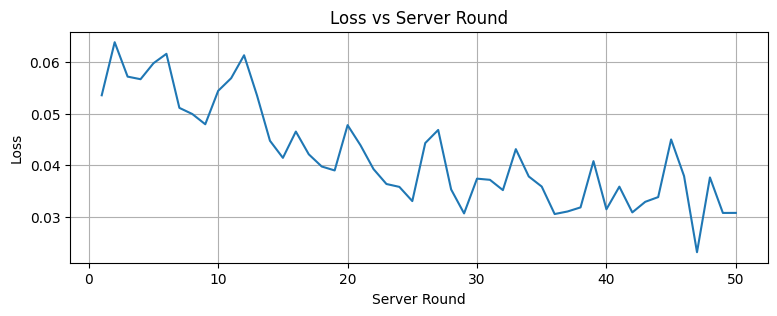

In [ ]:
def plot_loss():
    plt.figure(figsize=(9,3))
    plt.plot(range(1, len(lossm_values) + 1), lossm_values, linestyle='-')
    plt.title('Loss vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss()

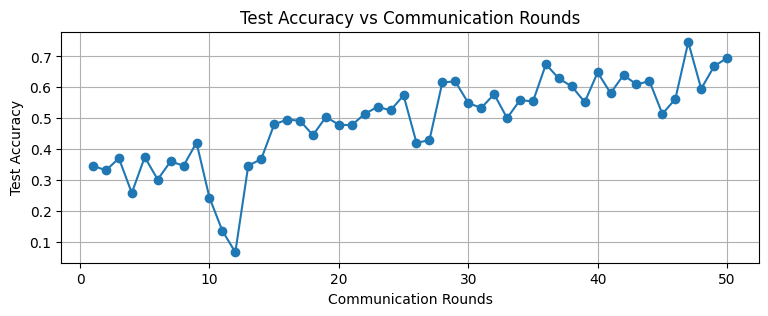

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(testm_accuracies) + 1), testm_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

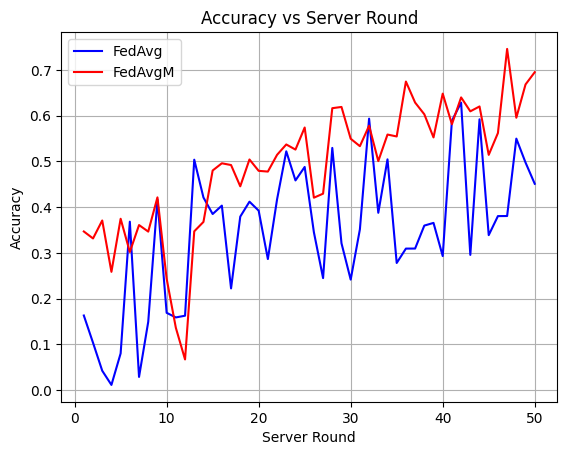

In [ ]:
def plot_accuracies():
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='FedAvg', color='blue', linestyle='-')
    plt.plot(range(1, len(testm_accuracies) + 1), testm_accuracies, label='FedAvgM', color='red', linestyle='-')
    plt.title('Accuracy vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies()

In [ ]:
def train(net,trainloader,epochs:int,global_params=None,mu:float=0.0,verbose=False): # adding proximal term coefficient (mu)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    # optimizer = torch.optim.Adam(net.parameters())
    net.train()

    for epoch in range(epochs):
        correct,total,epoch_loss=0,0,0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs=net(images)
            ce_loss=criterion(outputs,labels)

            # If global model parameters are given and mu is non-zero, apply FedProx algorithm
            if global_params is not None and mu>0:
                prox_term=0.0
                for param,global_param in zip(net.parameters(),global_params):
                    prox_term+=((param-global_param.to(DEVICE))**2).sum()
                ce_loss+=(mu/2)*prox_term # Adding the proximal penalty to the cross-entropy loss

            ce_loss.backward()
            optimizer.step()
            epoch_loss+=ce_loss.item()
            total+=labels.size(0)
            correct+=(outputs.argmax(dim=1)==labels).sum().item()

        if verbose:
            print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Accuracy = {correct / total:.4f}")

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net=net
        self.trainloader=trainloader
        self.valloader=valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net,parameters)
        mu=float(config.get("mu",0.0))
        global_params=[torch.tensor(p,dtype=torch.float32).to(DEVICE) for p in parameters]
        train(self.net,self.trainloader,epochs=1,global_params=global_params,mu=mu)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
from flwr.server.strategy import FedProx

fedprox_accuracies = []
lossp_values = []

class CustomFedProx(FedProx):
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_result = super().aggregate_evaluate(server_round, results, failures)

        if aggregated_result is not None:
            loss, metrics = aggregated_result
            accuracy = metrics.get("accuracy", 0.0)
            fedprox_accuracies.append(accuracy)
            lossp_values.append(loss)
            print(f"Round {server_round}: Loss: {loss:.4f} Test Accuracy: {accuracy:.4f}")

        return aggregated_result

In [ ]:
strategy_fedprox = CustomFedProx(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    proximal_mu=0.01
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=50)
    return ServerAppComponents(strategy=strategy_fedprox, config=config)

server = ServerApp(server_fn=server_fn)

backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [ ]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(pid=33442) 2025-05-01 02:24:27.135882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=33442) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=33442) E0000 00:00:1746066267.171475   33442 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=33442) E0000 00:00:1746066267.181681   33442 cuda_blas.cc:1418] Unable to register cuBLAS factor

(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 1: Loss: 0.0455 Test Accuracy: 0.5282
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': 

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 2: Loss: 0.0337 Test Accuracy: 0.6493
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 16901286175081476592, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 3: Loss: 0.0765 Test Accuracy: 0.2436
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 4: Loss: 0.0315 Test Accuracy: 0.6515
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partitio

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 5: Loss: 0.0349 Test Accuracy: 0.6094
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 6: Loss: 0.0469 Test Accuracy: 0.5073
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}

(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 17709879317212616795, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 5


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 5 size: 4272
(ClientAppActor pid=33442) Partition 5 train size: 3417
(ClientAppActor pid=33442) Partition 5 test size: 855
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 16901286175081476592, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 2


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 2 size: 2133
(ClientAppActor pid=33442) Partition 2 train size: 1706
(ClientAppActor pid=33442) Partition 2 test size: 427
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0
(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 17709879317212616795, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 7: Loss: 0.0644 Test Accuracy: 0.3227
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 8: Loss: 0.0538 Test Accuracy: 0.4020
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 9: Loss: 0.0351 Test Accuracy: 0.6047
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': 

(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 7990446498321807810, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 17709879317212616795, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 5


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 5 size: 4272
(ClientAppActor pid=33442) Partition 5 train size: 3417
(ClientAppActor pid=33442) Partition 5 test size: 855
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 16901286175081476592, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 2


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 2 size: 2133
(ClientAppActor pid=33442) Partition 2 train size: 1706
(ClientAppActor pid=33442) Partition 2 test size: 427
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 3


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 14828864481674414374, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 4


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 4 size: 7143
(ClientAppActor pid=33442) Partition 4 train size: 5714
(ClientAppActor pid=33442) Partition 4 test size: 1429


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 3
(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 10: Loss: 0.0366 Test Accuracy: 0.5773
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 11: Loss: 0.0432 Test Accuracy: 0.5294
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 12: Loss: 0.0511 Test Accuracy: 0.4606
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)  

(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 4 size: 7143
(ClientAppActor pid=33442) Partition 4 train size: 5714
(ClientAppActor pid=33442) Partition 4 test size: 1429
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 3


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0
(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)

ERROR :     An exception was raised when processing a message by RayBackend
ERROR :     ray::ClientAppActor.run() (pid=33442, ip=172.28.0.12, actor_id=f34bf7bdb59f646a57beb66301000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7c6a9c4a7c10>)
  File "/usr/local/lib/python3.11/dist-packages/requests/models.py", line 1024, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 429 Client Error: Too Many Requests for url: https://huggingface.co/api/datasets/cifar10/paths-info/0b2714987fa478483af9968de7c934580d0bb9a2

The above exception was the direct cause of the following exception:

ray::ClientAppActor.run() (pid=33442, ip=172.28.0.12, actor_id=f34bf7bdb59f646a57beb66301000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x7c6a9c4a7c10>)
  File "/usr/local/lib/python3.11/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 58, in run
    out_message = app(message=message, 

(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 16901286175081476592, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 2


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 2 size: 2133
(ClientAppActor pid=33442) Partition 2 train size: 1706
(ClientAppActor pid=33442) Partition 2 test size: 427


INFO :      aggregate_fit: received 9 results and 1 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 3


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0
(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 7990446498321807810, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 13: Loss: 0.0401 Test Accuracy: 0.5643
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   ar

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 14: Loss: 0.0453 Test Accuracy: 0.5074
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 15: Loss: 0.0307 Test Accuracy: 0.6481
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 16: Loss: 0.0322 Test Accuracy: 0.6350
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 17: Loss: 0.0271 Test Accuracy: 0.7196
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 18: Loss: 0.0310 Test Accuracy: 0.6710
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 17709879317212616795, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 5


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 5 size: 4272
(ClientAppActor pid=33442) Partition 5 train size: 3417
(ClientAppActor pid=33442) Partition 5 test size: 855
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 14828864481674414374, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 4


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 4 size: 7143
(ClientAppActor pid=33442) Partition 4 train size: 5714
(ClientAppActor pid=33442) Partition 4 test size: 1429
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 7990446498321807810, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 3
(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 16901286175081476592, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 19: Loss: 0.0379 Test Accuracy: 0.5805
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) 
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppAc

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 20: Loss: 0.0352 Test Accuracy: 0.6165
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   ar

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 21: Loss: 0.0321 Test Accuracy: 0.6552
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config'

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 22: Loss: 0.0301 Test Accuracy: 0.6678
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   a

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 23: Loss: 0.0278 Test Accuracy: 0.7020
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 24: Loss: 0.0307 Test Accuracy: 0.6747
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 25: Loss: 0.0331 Test Accuracy: 0.6451
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 26: Loss: 0.0235 Test Accuracy: 0.7581
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config'

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 27: Loss: 0.0262 Test Accuracy: 0.7307
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 28: Loss: 0.0318 Test Accuracy: 0.6695
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)  

(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 5 size: 4272
(ClientAppActor pid=33442) Partition 5 train size: 3417
(ClientAppActor pid=33442) Partition 5 test size: 855
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 7990446498321807810, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442) 

(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 4 size: 7143
(ClientAppActor pid=33442) Partition 4 train size: 5714
(ClientAppActor pid=33442) Partition 4 test size: 1429
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 3


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 16901286175081476592, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 2


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 2 size: 2133
(ClientAppActor pid=33442) Partition 2 train size: 1706
(ClientAppActor pid=33442) Partition 2 test size: 427
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 17709879317212616795, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 5
(ClientAppActor pid=33442) Partition 5 size: 4272
(ClientAppActor pid=33442) Partition 5 train size: 3417
(ClientAppActor pid=33442) Partition 5 test size: 855
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 14828864481674414374, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 29: Loss: 0.0258 Test Accuracy: 0.7342
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 30: Loss: 0.0335 Test Accuracy: 0.6596
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 16901286175081476592, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 31: Loss: 0.0271 Test Accuracy: 0.7211
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 32: Loss: 0.0336 Test Accuracy: 0.6514
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 16901286175081476592, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 33: Loss: 0.0484 Test Accuracy: 0.5330
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)  

(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 2 size: 2133
(ClientAppActor pid=33442) Partition 2 train size: 1706
(ClientAppActor pid=33442) Partition 2 test size: 427
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 17709879317212616795, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 5


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 5 size: 4272
(ClientAppActor pid=33442) Partition 5 train size: 3417
(ClientAppActor pid=33442) Partition 5 test size: 855
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 7990446498321807810, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 14828864481674414374, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 4


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 4 size: 7143
(ClientAppActor pid=33442) Partition 4 train size: 5714
(ClientAppActor pid=33442) Partition 4 test size: 1429
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 3


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0
(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 17709879317212616795, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 34: Loss: 0.0307 Test Accuracy: 0.6937
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 35: Loss: 0.0263 Test Accuracy: 0.7302
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 36: Loss: 0.0254 Test Accuracy: 0.7511
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 37: Loss: 0.0281 Test Accuracy: 0.7169
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 38: Loss: 0.0302 Test Accuracy: 0.7125
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 39: Loss: 0.0300 Test Accuracy: 0.7225
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 40: Loss: 0.0271 Test Accuracy: 0.7398
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 3
(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 16901286175081476592, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 41: Loss: 0.0290 Test Accuracy: 0.7156
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 42: Loss: 0.0331 Test Accuracy: 0.6958
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   ar

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 43: Loss: 0.0330 Test Accuracy: 0.6754
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 44: Loss: 0.0385 Test Accuracy: 0.6381
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 14828864481674414374, 'node_config': {'partition-id': 9, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 4


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 4 size: 7143
(ClientAppActor pid=33442) Partition 4 train size: 5714
(ClientAppActor pid=33442) Partition 4 test size: 1429
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 17709879317212616795, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 5


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 5 size: 4272
(ClientAppActor pid=33442) Partition 5 train size: 3417
(ClientAppActor pid=33442) Partition 5 test size: 855
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 7990446498321807810, 'node_config': {'partition-id': 8, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 16901286175081476592, 'node_config': {'partition-id': 5, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 2


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 2 size: 2133
(ClientAppActor pid=33442) Partition 2 train size: 1706
(ClientAppActor pid=33442) Partition 2 test size: 427
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 45: Loss: 0.0245 Test Accuracy: 0.7886
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
Round 46: Loss: 0.0367 Test Accuracy: 0.6535
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)  

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 3
(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partiti

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 47: Loss: 0.0272 Test Accuracy: 0.7419
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 2 size: 2133
(ClientAppActor pid=33442) Partition 2 train size: 1706
(ClientAppActor pid=33442) Partition 2 test size: 427
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 10157134366020742570, 'node_config': {'partition-id': 6, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 0


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 0 size: 474
(ClientAppActor pid=33442) Partition 0 train size: 379
(ClientAppActor pid=33442) Partition 0 test size: 95
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 17709879317212616795, 'node_config': {'partition-id': 7, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 5


(ClientAppActor pid=33442) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=33442) Found the latest cached dataset configuration 'plain_text' at /root/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Thu May  1 02:24:55 2025).


(ClientAppActor pid=33442) Partition 5 size: 4272
(ClientAppActor pid=33442) Partition 5 train size: 3417
(ClientAppActor pid=33442) Partition 5 test size: 855
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 3
(ClientAppActor pid=33442) Partition 3 size: 4835
(ClientAppActor pid=33442) Partition 3 train size: 3868
(ClientAppActor pid=33442) Partition 3 test size: 967
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=334

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 48: Loss: 0.0317 Test Accuracy: 0.7074
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 1601849891618046591, 'node_config': {'partition-id': 1, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 1
(ClientAppActor pid=33442) Partition 1 size: 940
(ClientAppActor pid=33442) Partition 1 train size: 752
(ClientAppActor pid=33442) Partition 1 test size: 188
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 15266655930491887889, 'node_config': {'partition-id': 0, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partit

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 49: Loss: 0.0297 Test Accuracy: 0.7237
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 18261693493148344053, 'node_config': {'partition-id': 3, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config':

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 3360588875314714539, 'node_config': {'partition-id': 2, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partition_id: 9
(ClientAppActor pid=33442) Partition 9 size: 4404
(ClientAppActor pid=33442) Partition 9 train size: 3523
(ClientAppActor pid=33442) Partition 9 test size: 881
(ClientAppActor pid=33442) Context data: {'run_id': 11659072542919751182, 'node_id': 2467928551185030659, 'node_config': {'partition-id': 4, 'num-partitions': 10}, 'state': RecordDict(
(ClientAppActor pid=33442)   array_records={},
(ClientAppActor pid=33442)   metric_records={},
(ClientAppActor pid=33442)   config_records={}
(ClientAppActor pid=33442) ), 'run_config': {}}
(ClientAppActor pid=33442) Using partitio

INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 2375.27s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.04551747449501123
INFO :      		round 2: 0.03370854745242683
INFO :      		round 3: 0.07650756453699102
INFO :      		round 4: 0.03149813060892776
INFO :      		round 5: 0.03490850906072375
INFO :      		round 6: 0.046897285090960285
INFO :      		round 7: 0.06439357935985675
INFO :      		round 8: 0.053828340819416245
INFO :      		round 9: 0.03506008514209239
INFO :      		round 10: 0.03661107528623077
INFO :      		round 11: 0.04317582551742808
INFO :      		round 12: 0.05107014706042648
INFO :      		round 13: 0.04012993245222947
INFO :      		round 14: 0.045297649900365604
INFO :      		round 15: 0.0306517304073585
INFO :      		round 16: 0.032210785850143454
INFO :      		round 17: 0.027130491825991365
INFO :      		round 18: 0.03104275841663738
INFO :      		round 1

Round 50: Loss: 0.0285 Test Accuracy: 0.7216


In [ ]:
print("\n===== SUMMARY OF TEST ACCURACIES =====")
for round_num, accuracy in enumerate(fedprox_accuracies, 1):
    print(f"Round {round_num}: {accuracy:.4f}")
print("=====================================\n")


===== SUMMARY OF TEST ACCURACIES =====



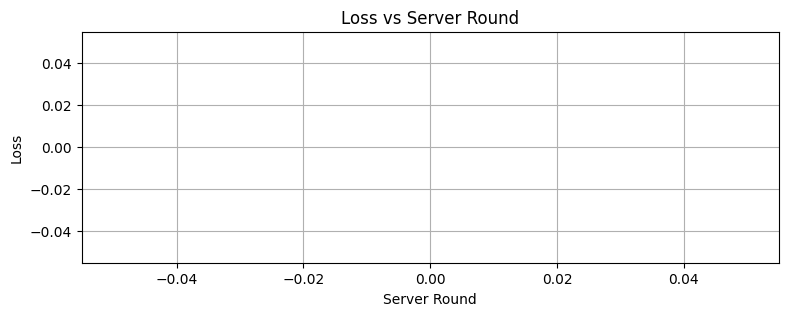

In [ ]:
def plot_loss():
    plt.figure(figsize=(9,3))
    plt.plot(range(1, len(lossp_values) + 1), lossp_values, linestyle='-')
    plt.title('Loss vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

plot_loss()

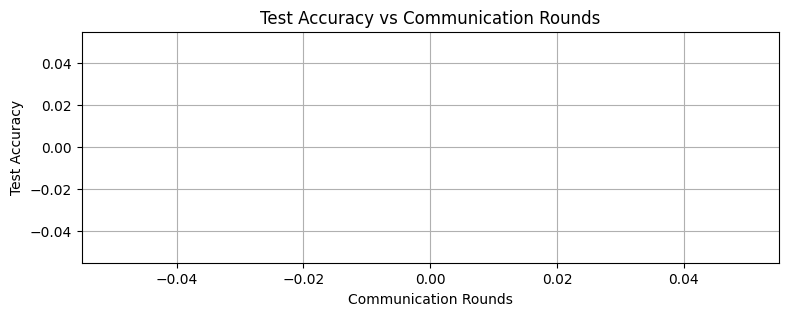

In [ ]:
def plot_accuracy_vs_rounds():
    if test_accuracies:
        plt.figure(figsize=(9,3))
        plt.plot(range(1, len(fedprox_accuracies) + 1), fedprox_accuracies, marker='o', linestyle='-')
        plt.title('Test Accuracy vs Communication Rounds')
        plt.xlabel('Communication Rounds')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()
    else:
        print("No accuracy data collected to plot.")

plot_accuracy_vs_rounds()

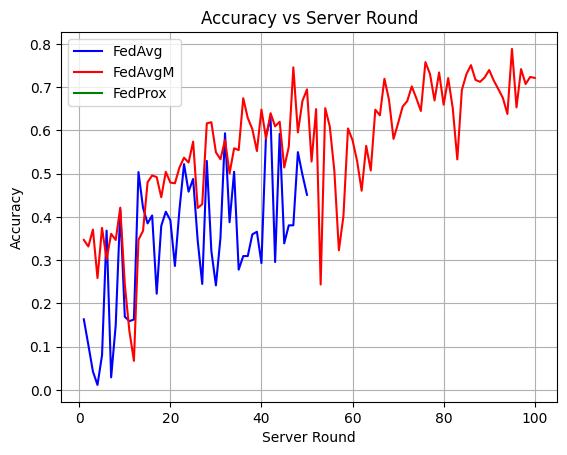

In [ ]:
def plot_accuracies():
    plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='FedAvg', color='blue', linestyle='-')
    plt.plot(range(1, len(testm_accuracies) + 1), testm_accuracies, label='FedAvgM', color='red', linestyle='-')
    plt.plot(range(1, len(fedprox_accuracies) + 1), fedprox_accuracies, label='FedProx', color='green', linestyle='-')

    plt.title('Accuracy vs Server Round')
    plt.xlabel('Server Round')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracies()